In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from math import isnan
from numpy.random import uniform
from random import sample
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# Data Loading And Exploration

In [53]:
data = pd.read_csv('Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [54]:
y = data.pop('country')
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [55]:
data.shape

(167, 9)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2)
memory usage: 11.8 KB


We have all variables as numbers.

### Check for outlier

In [57]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
data.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,70.800000,10.940000,75.420000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,80.570000,11.570000,81.140000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,160.480000,13.474000,146.080000,84374.000000,41.478000,82.370000,6.563600,79088.000000


Looks like the numbers are increasing gradually. Therefore, there are no outliers that needs to be treated.

{'whiskers': [<matplotlib.lines.Line2D at 0x127082c88>,
 'caps': [<matplotlib.lines.Line2D at 0x12708b358>,
 'boxes': [<matplotlib.lines.Line2D at 0x127082898>],
 'medians': [<matplotlib.lines.Line2D at 0x12708b9e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12708bd30>],
 'means': []}

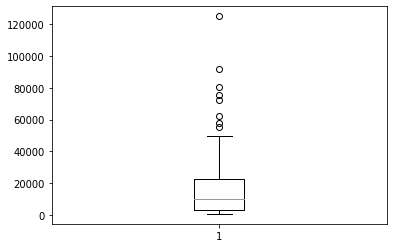

In [58]:
plt.boxplot(data['income'])

In [59]:
Q1 = data.quantile(0.05)
Q3 = data.quantile(0.95)
IQR = Q3 - Q1
print(IQR)

child_mort      112.5400
exports          68.4500
health            8.7790
imports          63.0100
income        47077.0000
inflation        20.6866
life_expec       25.6200
total_fer         4.4710
gdpp          48144.1000
dtype: float64


In [60]:
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,38.105488,40.107311,6.874268,46.435768,16225.079268,7.247756,70.488415,2.946646,12474.292683
std,39.896529,24.598063,2.730949,22.112332,16936.812864,7.505487,8.861355,1.502677,17722.307006
min,2.600000,0.109000,1.970000,0.065900,609.000000,-4.210000,32.100000,1.230000,231.000000
25%,8.425000,23.725000,4.960000,30.625000,3335.000000,1.830000,65.300000,1.797500,1310.000000
50%,19.500000,35.000000,6.400000,43.300000,9950.000000,5.265000,73.100000,2.410000,4635.000000
75%,62.050000,51.225000,8.670000,58.675000,22400.000000,10.675000,76.725000,3.865000,13500.000000
90%,99.010000,69.850000,10.970000,73.590000,40980.000000,16.600000,80.400000,5.298000,40090.000000
95%,115.700000,77.685000,11.585000,80.880000,45485.000000,20.785000,81.385000,5.862500,48250.000000
99%,153.700000,121.500000,13.507000,120.580000,77198.000000,31.199000,82.074000,6.564800,79484.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x1272a37f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1272a3e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1272a3400>],
 'medians': [<matplotlib.lines.Line2D at 0x1272b1550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1272b1898>],
 'means': []}

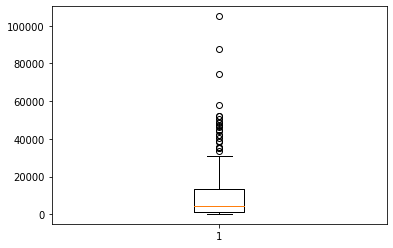

In [61]:
plt.boxplot(data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]['gdpp'])

{'whiskers': [<matplotlib.lines.Line2D at 0x127304a58>,
 'caps': [<matplotlib.lines.Line2D at 0x127304e48>,
 'boxes': [<matplotlib.lines.Line2D at 0x127304668>],
 'medians': [<matplotlib.lines.Line2D at 0x1273137b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x127313b00>],
 'means': []}

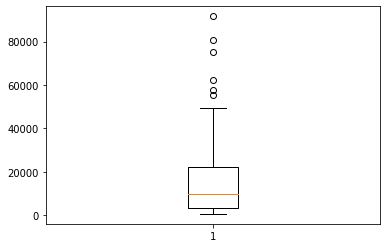

In [62]:
plt.boxplot(data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]['income'])

### Checking for Missing Values

In [63]:
# Checking the percentage of missing values
round(100 * (data.isnull().sum() / len(data.index)), 2)

child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

There are no missing values

# Scale the Data

In [64]:
scaler = StandardScaler()

X = data.copy()
x = scaler.fit_transform(X)

x[:5,:5]

array([[ 1.30973967, -1.22771955,  0.25921146, -0.06966572, -0.86556086],
       [-0.54068249, -0.49371339, -0.119102  ,  0.09817422, -0.37281866],
       [-0.27166731, -0.06962093, -0.99326321, -0.68205468, -0.1969239 ],
       [ 2.03381791,  0.90497615, -1.47809211, -0.16039001, -0.61149066],
       [-0.6990746 ,  0.21990372, -0.31009521,  0.56540431,  0.17026379]])

# Applying PCA

In [65]:
pca = PCA(random_state=42)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [66]:
# The new basis
pca.components_

array([[-0.41707142,  0.26416786,  0.18768908,  0.13037811,  0.41046939,
        -0.19325685,  0.42525158, -0.4006349 ,  0.39605627],
       [ 0.16626965,  0.60959466, -0.14025508,  0.71387142, -0.01780182,
        -0.06583848, -0.2178763 ,  0.13068815, -0.04757916],
       [-0.17969762,  0.23818157, -0.67428713, -0.17159462,  0.1205389 ,
         0.60477777,  0.15830297, -0.11626924, -0.08947802],
       [ 0.34764414,  0.09856524,  0.19229972, -0.17589757,  0.47140389,
         0.33594745, -0.18172433,  0.38900432,  0.531111  ],
       [-0.18183315, -0.01302907,  0.60352928,  0.2518542 , -0.19656821,
         0.67595776,  0.05069234, -0.10140126, -0.17515404],
       [ 0.21153109, -0.04075914,  0.00361447, -0.05029309,  0.15419872,
         0.05496542, -0.60272783, -0.74866795,  0.02162972],
       [-0.06947963, -0.68136406, -0.28952827,  0.57355282,  0.08180463,
         0.11899188,  0.00187661,  0.01061626,  0.31170314],
       [ 0.72455736,  0.01039262, -0.0157946 ,  0.05284916, -0

In [67]:
# How much variance is being explained by each Principal Component
pca.explained_variance_ratio_

array([0.46176255, 0.1699294 , 0.13516563, 0.10906535, 0.06795329,
       0.0254524 , 0.01460331, 0.00919995, 0.00686812])

<BarContainer object of 9 artists>

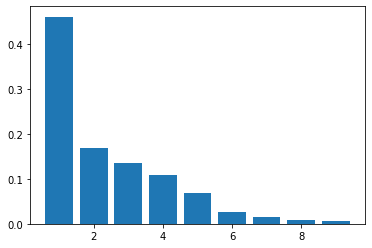

In [68]:
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)

The first PC, i.e. Principal Component 1 explains the maximum information (46%) in the dataset followed by PC2 at 17% and PC3 at 13%.

### Scree Plot

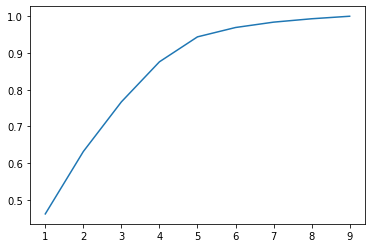

In [69]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(var_cumu) + 1), var_cumu)

Cumulative variance explained by the top 4 principal components is the sum of their individual variances, given by 46 + 17 + 13 + 11 = 87%

# PCA with 4 Components

In [70]:
pc2 = PCA(n_components=4, random_state=42)
new_data = pc2.fit_transform(x)

In [71]:
# Only 5 columns instead of 9
new_data.shape

(164, 4)

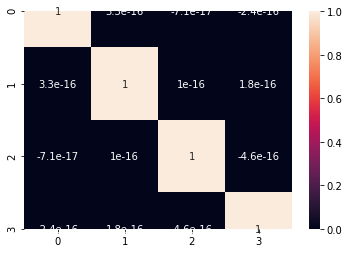

In [72]:
corrmat = np.corrcoef(new_data.transpose())
sns.heatmap(corrmat, annot=True)

In [73]:
# Convert to DF for convenience
df = pd.DataFrame(new_data, columns=['pc1', 'pc2', 'pc3', 'pc4'])
df.head()

,pc1,pc2,pc3,pc4
0,-2.966365,0.014543,-1.036420,0.768485
1,0.442288,-0.507039,0.022429,-1.284641
2,-0.365026,-0.641205,1.663468,-0.247008
3,-3.109768,1.420818,1.634979,1.711483
4,1.101124,0.286844,0.019053,-0.911061


In [74]:
# PC with classes
df_final = pd.concat([df, y], axis=1)
df_final.head()

,pc1,pc2,pc3,pc4,country
0,-2.966365,0.014543,-1.036420,0.768485,Afghanistan
1,0.442288,-0.507039,0.022429,-1.284641,Albania
2,-0.365026,-0.641205,1.663468,-0.247008,Algeria
3,-3.109768,1.420818,1.634979,1.711483,Angola
4,1.101124,0.286844,0.019053,-0.911061,Antigua and Barbuda


# Clustering
### Hopkins Statistics

In [75]:
def hopkins(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [76]:
hopkins(df)

0.7978329158759434

# Modelling

### Finding optimal number of clusters

##### Elbow-curve or Sum of Squared distances (SSD)

In [77]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

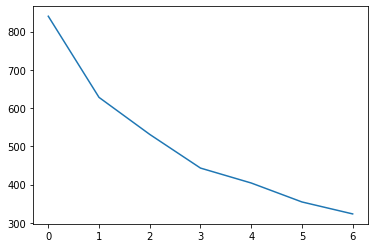

In [78]:
ssd = []
for num_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=num_cluster, max_iter=50)
    kmeans.fit(df)
    ssd.append(kmeans.inertia_)
    
# Plot the SSDs for each n number of clusters
plt.plot(ssd)

##### Silhouette Analysis

In [79]:
for num_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=num_cluster, max_iter=50)
    kmeans.fit(df)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(f'For {num_cluster} clusters, silhouette score is {silhouette_avg}')

For 2 clusters, silhouette score is 0.31651552968059704
For 3 clusters, silhouette score is 0.32301516564028715
For 4 clusters, silhouette score is 0.28914216969675627
For 5 clusters, silhouette score is 0.3072148593600267
For 6 clusters, silhouette score is 0.29716201497996814
For 7 clusters, silhouette score is 0.29050353054797395
For 8 clusters, silhouette score is 0.269560213712501


# Hierarchical Clustering

### Single Linkage

In [80]:
mergings = linkage(df, method='single', metric='euclidean')

In [81]:
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1,)
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0])

In [82]:
# Assign cluster labels
final_df = df.copy()
final_df['cluster_id'] = cluster_labels
final_df['country'] = y
final_df.head()

,pc1,pc2,pc3,pc4,cluster_id,country
0,-2.966365,0.014543,-1.036420,0.768485,0,Afghanistan
1,0.442288,-0.507039,0.022429,-1.284641,0,Albania
2,-0.365026,-0.641205,1.663468,-0.247008,0,Algeria
3,-3.109768,1.420818,1.634979,1.711483,0,Angola
4,1.101124,0.286844,0.019053,-0.911061,0,Antigua and Barbuda


In [83]:
cluster_dict = {}

for cluster_id in final_df['cluster_id'].unique():
    cluster_countries = list(final_df[final_df['cluster_id'] == cluster_id]['country'])
    cluster_dict[cluster_id] = cluster_countries

cluster_dict

{0: ['Afghanistan',
  'Albania',
  'Algeria',
  'Angola',
  'Antigua and Barbuda',
  'Argentina',
  'Armenia',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahamas',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bhutan',
  'Bolivia',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'Brunei',
  'Bulgaria',
  'Burkina Faso',
  'Burundi',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cape Verde',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Colombia',
  'Comoros',
  'Congo, Dem. Rep.',
  'Congo, Rep.',
  'Costa Rica',
  "Cote d'Ivoire",
  'Croatia',
  'Cyprus',
  'Czech Republic',
  'Denmark',
  'Dominican Republic',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Equatorial Guinea',
  'Eritrea',
  'Estonia',
  'Fiji',
  'Finland',
  'France',
  'Gabon',
  'Gambia',
  'Georgia',
  'Germany',
  'Ghana',
  'Greece',
  'Grenada',
  'Guatemala',
  'Guinea',
  'Guinea-Bissau',
  'Guyana',
  'Haiti',
  'Hungary',
  'Iceland'

### Complete Linkage

In [84]:
mergings = linkage(df, method='complete', metric='euclidean')

In [85]:
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1,)
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 3, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 3, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0])

In [86]:
# Assign cluster labels
final_df = df.copy()
final_df['cluster_id'] = cluster_labels
final_df['country'] = y
final_df.head()

,pc1,pc2,pc3,pc4,cluster_id,country
0,-2.966365,0.014543,-1.036420,0.768485,0,Afghanistan
1,0.442288,-0.507039,0.022429,-1.284641,0,Albania
2,-0.365026,-0.641205,1.663468,-0.247008,0,Algeria
3,-3.109768,1.420818,1.634979,1.711483,0,Angola
4,1.101124,0.286844,0.019053,-0.911061,1,Antigua and Barbuda


In [87]:
cluster_dict = {}

for cluster_id in final_df['cluster_id'].unique():
    cluster_countries = list(final_df[final_df['cluster_id'] == cluster_id]['country'])
    cluster_dict[cluster_id] = cluster_countries

cluster_dict

{0: ['Afghanistan',
  'Albania',
  'Algeria',
  'Angola',
  'Argentina',
  'Armenia',
  'Azerbaijan',
  'Bangladesh',
  'Benin',
  'Bolivia',
  'Botswana',
  'Brazil',
  'Burkina Faso',
  'Burundi',
  'Cameroon',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Colombia',
  'Comoros',
  'Congo, Dem. Rep.',
  'Congo, Rep.',
  "Cote d'Ivoire",
  'Dominican Republic',
  'Ecuador',
  'Egypt',
  'Equatorial Guinea',
  'Eritrea',
  'Gabon',
  'Gambia',
  'Ghana',
  'Guatemala',
  'Guinea',
  'Guinea-Bissau',
  'Haiti',
  'India',
  'Indonesia',
  'Iran',
  'Iraq',
  'Jamaica',
  'Kazakhstan',
  'Kenya',
  'Kiribati',
  'Lao',
  'Lesotho',
  'Liberia',
  'Madagascar',
  'Malawi',
  'Mali',
  'Mauritania',
  'Micronesia, Fed. Sts.',
  'Mongolia',
  'Mozambique',
  'Myanmar',
  'Namibia',
  'Nepal',
  'Niger',
  'Oman',
  'Paraguay',
  'Peru',
  'Portugal',
  'Qatar',
  'Romania',
  'Russia',
  'Samoa',
  'Serbia',
  'Singapore',
  'Slovak Republic',
  'South Africa',
  'Spain',

# K-Means

In [88]:
# K-means with some arbitrary K
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [89]:
kmeans.labels_

array([0, 2, 1, 0, 2, 1, 1, 3, 3, 1, 2, 2, 1, 2, 2, 3, 2, 0, 2, 1, 2, 0,
       1, 3, 2, 0, 0, 2, 0, 3, 2, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 2, 3, 2,
       3, 1, 1, 1, 2, 0, 0, 2, 2, 3, 3, 1, 0, 2, 3, 0, 3, 2, 1, 0, 0, 2,
       0, 2, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 2, 1, 0, 0, 3, 2, 0, 2, 2, 0,
       0, 1, 2, 3, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 1, 0, 1,
       3, 3, 0, 3, 1, 0, 2, 2, 1, 1, 2, 3, 2, 1, 0, 2, 1, 0, 2, 2, 0, 2,
       3, 2, 0, 2, 3, 1, 2, 0, 2, 3, 3, 1, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2,
       3, 3, 3, 1, 1, 2, 1, 2, 1, 0], dtype=int32)

In [90]:
# Assign cluster labels
final_df = df.copy()
final_df['cluster_id'] = kmeans.labels_
final_df['country'] = y
final_df.head()

,pc1,pc2,pc3,pc4,cluster_id,country
0,-2.966365,0.014543,-1.036420,0.768485,0,Afghanistan
1,0.442288,-0.507039,0.022429,-1.284641,2,Albania
2,-0.365026,-0.641205,1.663468,-0.247008,1,Algeria
3,-3.109768,1.420818,1.634979,1.711483,0,Angola
4,1.101124,0.286844,0.019053,-0.911061,2,Antigua and Barbuda


In [91]:
cluster_dict = {}

for cluster_id in final_df['cluster_id'].unique():
    cluster_countries = list(final_df[final_df['cluster_id'] == cluster_id]['country'])
    cluster_dict[cluster_id] = cluster_countries

cluster_dict

{0: ['Afghanistan',
  'Angola',
  'Benin',
  'Botswana',
  'Burkina Faso',
  'Burundi',
  'Cameroon',
  'Central African Republic',
  'Chad',
  'Comoros',
  'Congo, Dem. Rep.',
  'Congo, Rep.',
  "Cote d'Ivoire",
  'Equatorial Guinea',
  'Eritrea',
  'Gambia',
  'Ghana',
  'Guinea',
  'Guinea-Bissau',
  'Haiti',
  'Kenya',
  'Kiribati',
  'Lao',
  'Lesotho',
  'Liberia',
  'Madagascar',
  'Malawi',
  'Mali',
  'Mauritania',
  'Mozambique',
  'Namibia',
  'Niger',
  'Oman',
  'Romania',
  'Samoa',
  'Serbia',
  'Slovak Republic',
  'Spain',
  'Sweden',
  'Tajikistan',
  'Tanzania',
  'Tunisia',
  'Venezuela'],
 2: ['Albania',
  'Antigua and Barbuda',
  'Bahamas',
  'Bahrain',
  'Barbados',
  'Belarus',
  'Belize',
  'Bhutan',
  'Bosnia and Herzegovina',
  'Bulgaria',
  'Cambodia',
  'Cape Verde',
  'Costa Rica',
  'Croatia',
  'Czech Republic',
  'El Salvador',
  'Estonia',
  'Fiji',
  'Georgia',
  'Grenada',
  'Guyana',
  'Hungary',
  'Jordan',
  'Kyrgyz Republic',
  'Latvia',
  'Leban

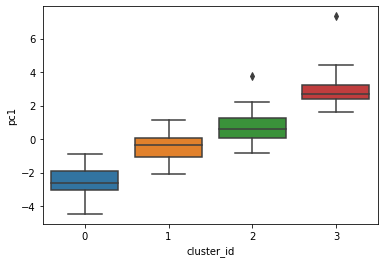

In [92]:
sns.boxplot(x='cluster_id', y='pc1', data=final_df)

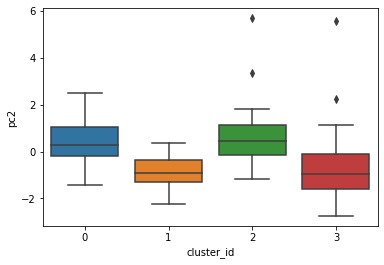

In [93]:
sns.boxplot(x='cluster_id', y='pc2', data=final_df)

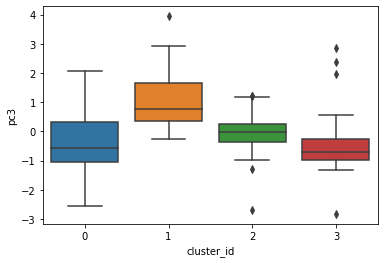

In [94]:
sns.boxplot(x='cluster_id', y='pc3', data=final_df)

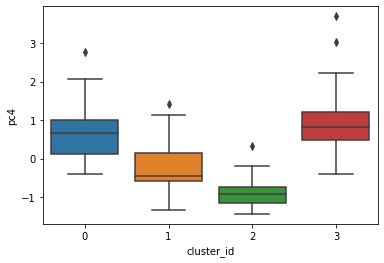

In [95]:
sns.boxplot(x='cluster_id', y='pc4', data=final_df)

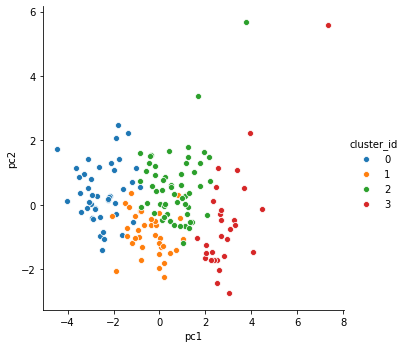

In [96]:
sns.pairplot(data=final_df, x_vars=['pc1'], y_vars=['pc2'], hue='cluster_id', size=5)

# Inference

In [97]:
data['cluster_id'] = kmeans.labels_
data['country'] = y
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,country
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,Afghanistan
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2,Albania
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,Algeria
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0,Angola
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2,Antigua and Barbuda


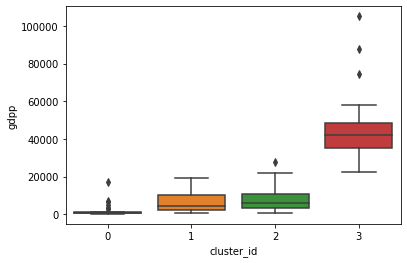

In [98]:
sns.boxplot(x='cluster_id', y='gdpp', data=data)

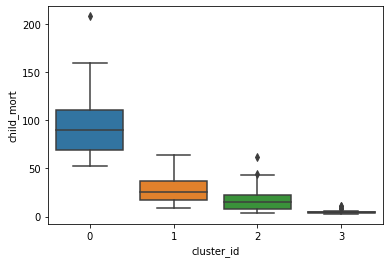

In [99]:
sns.boxplot(x='cluster_id', y='child_mort', data=data)

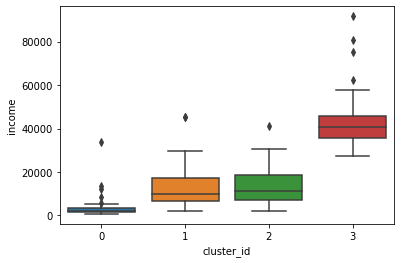

In [100]:
sns.boxplot(x='cluster_id', y='income', data=data)

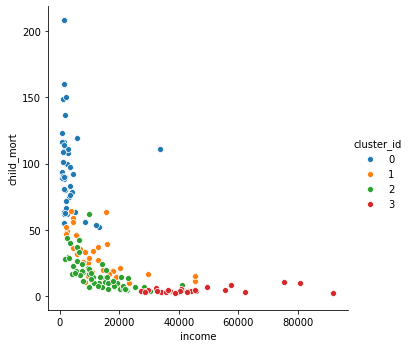

In [101]:
sns.pairplot(data=data, x_vars=['income'], y_vars=['child_mort'], hue='cluster_id', size=5)

In [104]:
cluster_dict[0]

['Afghanistan',
 'Angola',
 'Benin',
 'Botswana',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Equatorial Guinea',
 'Eritrea',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Kenya',
 'Kiribati',
 'Lao',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mozambique',
 'Namibia',
 'Niger',
 'Oman',
 'Romania',
 'Samoa',
 'Serbia',
 'Slovak Republic',
 'Spain',
 'Sweden',
 'Tajikistan',
 'Tanzania',
 'Tunisia',
 'Venezuela']

They should focus on these countries above since they are in need of dire aid. They have the highest child mortality rate and the least income.